# Face and Mask

In [1]:
import cv2
import matplotlib.pyplot as plt
import helpers
import numpy as np
import tensorflow as tf
import glob
import random
from retinaface import RetinaFace
from PIL import Image
from od_metrics.BoundingBox import BoundingBox
from od_metrics.BoundingBoxes import BoundingBoxes
from od_metrics.utils import BBFormat, BBType
from od_metrics.Evaluator import Evaluator
use_pickle = False

## Load Kaggle Dataset
Kaggle dataset has 853 images

In [2]:
# load images and associated faces
# this takes a second since we load with cv2
imgs_with_labels = helpers.load_kaggle_863('../kaggle_dataset_863')
imgs_with_labels = helpers.convert_kaggle_863_for_metrics(imgs_with_labels)

## Facial Recognition
We use retinaface to detect facial features

In [3]:
# Initialize facial detection
detector = RetinaFace(quality = "normal")

model[normal quality] init ..
model success !


In [4]:
dl_detection_results = {}
dl_detection_results['retinaface_mobilenet_alt'] = imgs_with_labels['bboxes'].clone()
detections = dl_detection_results['retinaface_mobilenet_alt']

In [13]:
imgs_with_labels['raw_data'].items()

dict_items([('maksssksksss604', {'img': array([[[176, 173, 170],
        [177, 175, 171],
        [178, 175, 172],
        ...,
        [182, 178, 177],
        [182, 178, 178],
        [182, 178, 178]],

       [[176, 173, 170],
        [177, 175, 171],
        [178, 175, 172],
        ...,
        [182, 178, 177],
        [182, 178, 177],
        [182, 178, 177]],

       [[176, 173, 170],
        [177, 174, 171],
        [178, 175, 172],
        ...,
        [182, 178, 177],
        [182, 178, 177],
        [182, 178, 177]],

       ...,

       [[141, 144, 148],
        [141, 141, 143],
        [144, 144, 144],
        ...,
        [ 99, 104, 110],
        [ 99, 105, 110],
        [100, 105, 111]],

       [[139, 141, 145],
        [138, 138, 140],
        [140, 139, 139],
        ...,
        [ 96, 102, 107],
        [ 98, 103, 109],
        [100, 105, 111]],

       [[137, 140, 144],
        [135, 135, 138],
        [137, 136, 136],
        ...,
        [ 96, 102, 109],
        [

In [5]:
#Detect faces and crop them, add the cropped Faces into cropImages

cropImages = []
cnt = 0
for img_name, img_data in imgs_with_labels['raw_data'].items():
    img = img_data['img']
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # using default threshold
    faces = detector.predict(rgb_img.astype(np.float32), threshold=0.7)
    
    #Crop faces and add them to cropImages
    img = Image.fromarray(rgb_img)
    cropFaces = []
    for face in faces:
        cropFaces.append(img.crop((face['x1'], face['y1'], face['x2'], face['y2'])))
        
    cropImages.append(cropFaces)
    
    cnt += 1
    if cnt%25 == 0: print(cnt)

25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850


## Mask Detection
we will now pass cropImages through the mask classifier

In [8]:
dim = 64

# I am passing in PIL images, this converts it to PIL
def resize_img(pic):
    image_array = tf.keras.preprocessing.image.img_to_array(pic)
    img = tf.convert_to_tensor(image_array, dtype = 'uint8')
    img = tf.image.resize(img, [dim, dim])
    img = img/127.5-1
    return img

In [9]:
# The neural network

def conv_model(num_blocks, rate, dim):
    
    input = tf.keras.layers.Input(shape=(dim,dim,3))
    
    x = tf.keras.layers.Conv2D(16, (16,16), strides=1)(input)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
        
    for i in range(num_blocks-1):
        x = tf.keras.layers.Conv2D(8, (8,8), strides=1)(x)
        x = tf.keras.layers.Dropout(rate)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
    x = tf.keras.layers.Conv2D(filters=2, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('softmax')(x)
    
    model = tf.keras.Model(inputs=input, outputs=predictions)
    print(model.summary())
    
    return model

In [10]:
num_blocks = 3
dropout = .1
model = conv_model(num_blocks,.1, dim)
model.load_weights('mask_classification_model_3_50.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 49, 49, 16)        12304     
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 49, 49, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 8)         8200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 8)         0     

In [11]:
# Prediction function, passes in PIL image
def pred(pic):
    im = resize_img(pic) # Convert and resize PIL image to 64x64 tensor
    vals = model.predict(np.expand_dims(im,axis=0))
    print(f"Mask Val: {vals[0][0]}, Non-mask Val: {vals[0][1]}")
    prediction = np.argmax(vals,axis=1)
    print(f"Image predicted as {prediction}")

In [12]:
for img in cropImages:
    for face in img:
        pred(face)

Mask Val: 0.11774208396673203, Non-mask Val: 0.8822579383850098
Image predicted as [1]
Mask Val: 0.16685953736305237, Non-mask Val: 0.8331404328346252
Image predicted as [1]
Mask Val: 0.9826881289482117, Non-mask Val: 0.017311837524175644
Image predicted as [0]
Mask Val: 0.9902515411376953, Non-mask Val: 0.00974851194769144
Image predicted as [0]
Mask Val: 0.9862380027770996, Non-mask Val: 0.013762053102254868
Image predicted as [0]
Mask Val: 0.02943778783082962, Non-mask Val: 0.970562219619751
Image predicted as [1]
Mask Val: 0.9884029030799866, Non-mask Val: 0.011597082950174809
Image predicted as [0]
Mask Val: 0.9484004974365234, Non-mask Val: 0.051599498838186264
Image predicted as [0]
Mask Val: 0.8974366784095764, Non-mask Val: 0.10256330668926239
Image predicted as [0]
Mask Val: 0.9989006519317627, Non-mask Val: 0.0010993293253704906
Image predicted as [0]
Mask Val: 0.9941182136535645, Non-mask Val: 0.005881754215806723
Image predicted as [0]
Mask Val: 0.9972623586654663, Non-mas

Mask Val: 0.9954830408096313, Non-mask Val: 0.004516909830272198
Image predicted as [0]
Mask Val: 0.9790119528770447, Non-mask Val: 0.020988060161471367
Image predicted as [0]
Mask Val: 0.4607311487197876, Non-mask Val: 0.5392689108848572
Image predicted as [1]
Mask Val: 0.5141015648841858, Non-mask Val: 0.4858984053134918
Image predicted as [0]
Mask Val: 0.8735059499740601, Non-mask Val: 0.12649403512477875
Image predicted as [0]
Mask Val: 0.9372426867485046, Non-mask Val: 0.06275730580091476
Image predicted as [0]
Mask Val: 0.9896236062049866, Non-mask Val: 0.010376319289207458
Image predicted as [0]
Mask Val: 0.9769513010978699, Non-mask Val: 0.023048697039484978
Image predicted as [0]
Mask Val: 0.9526138305664062, Non-mask Val: 0.04738617688417435
Image predicted as [0]
Mask Val: 0.9011161923408508, Non-mask Val: 0.09888381510972977
Image predicted as [0]
Mask Val: 0.9920111298561096, Non-mask Val: 0.0079888254404068
Image predicted as [0]
Mask Val: 0.963561475276947, Non-mask Val:

Mask Val: 0.9500105381011963, Non-mask Val: 0.0499894842505455
Image predicted as [0]
Mask Val: 0.9945148229598999, Non-mask Val: 0.005485233385115862
Image predicted as [0]
Mask Val: 0.6668695211410522, Non-mask Val: 0.333130419254303
Image predicted as [0]
Mask Val: 0.981145977973938, Non-mask Val: 0.01885402388870716
Image predicted as [0]
Mask Val: 0.3413151800632477, Non-mask Val: 0.6586847901344299
Image predicted as [1]
Mask Val: 0.9999974966049194, Non-mask Val: 2.5190136057062773e-06
Image predicted as [0]
Mask Val: 0.23446667194366455, Non-mask Val: 0.7655332684516907
Image predicted as [1]
Mask Val: 0.9440913796424866, Non-mask Val: 0.05590864270925522
Image predicted as [0]
Mask Val: 0.996094286441803, Non-mask Val: 0.003905719378963113
Image predicted as [0]
Mask Val: 0.9816474318504333, Non-mask Val: 0.0183525700122118
Image predicted as [0]
Mask Val: 0.9964409470558167, Non-mask Val: 0.003559047356247902
Image predicted as [0]
Mask Val: 0.9389278888702393, Non-mask Val: 

Mask Val: 0.9959959983825684, Non-mask Val: 0.004004011396318674
Image predicted as [0]
Mask Val: 0.004057972691953182, Non-mask Val: 0.9959420561790466
Image predicted as [1]
Mask Val: 0.9951469302177429, Non-mask Val: 0.0048530977219343185
Image predicted as [0]
Mask Val: 0.9942280054092407, Non-mask Val: 0.005771946161985397
Image predicted as [0]
Mask Val: 0.9879442453384399, Non-mask Val: 0.012055687606334686
Image predicted as [0]
Mask Val: 0.09158682078123093, Non-mask Val: 0.9084131717681885
Image predicted as [1]
Mask Val: 0.5249241590499878, Non-mask Val: 0.4750758707523346
Image predicted as [0]
Mask Val: 0.8495666980743408, Non-mask Val: 0.15043333172798157
Image predicted as [0]
Mask Val: 0.9954828023910522, Non-mask Val: 0.004517235793173313
Image predicted as [0]
Mask Val: 0.9944567680358887, Non-mask Val: 0.005543231498450041
Image predicted as [0]
Mask Val: 0.9855533242225647, Non-mask Val: 0.014446726068854332
Image predicted as [0]
Mask Val: 0.9922164678573608, Non-m

Mask Val: 0.13070857524871826, Non-mask Val: 0.869291365146637
Image predicted as [1]
Mask Val: 0.05134011432528496, Non-mask Val: 0.9486599564552307
Image predicted as [1]
Mask Val: 0.8955184817314148, Non-mask Val: 0.10448157042264938
Image predicted as [0]
Mask Val: 0.9238327145576477, Non-mask Val: 0.07616731524467468
Image predicted as [0]
Mask Val: 0.9036445021629333, Non-mask Val: 0.09635542333126068
Image predicted as [0]
Mask Val: 0.9871551990509033, Non-mask Val: 0.012844791635870934
Image predicted as [0]
Mask Val: 0.03724905475974083, Non-mask Val: 0.9627509713172913
Image predicted as [1]
Mask Val: 0.8797109723091125, Non-mask Val: 0.12028905749320984
Image predicted as [0]
Mask Val: 0.9580385684967041, Non-mask Val: 0.04196138307452202
Image predicted as [0]
Mask Val: 0.950669527053833, Non-mask Val: 0.04933048039674759
Image predicted as [0]
Mask Val: 0.048603225499391556, Non-mask Val: 0.9513967633247375
Image predicted as [1]
Mask Val: 0.8696602582931519, Non-mask Val:

Mask Val: 0.8585748076438904, Non-mask Val: 0.1414252072572708
Image predicted as [0]
Mask Val: 0.7876909971237183, Non-mask Val: 0.2123090773820877
Image predicted as [0]
Mask Val: 0.03329023718833923, Non-mask Val: 0.9667097926139832
Image predicted as [1]
Mask Val: 0.5302403569221497, Non-mask Val: 0.46975964307785034
Image predicted as [0]
Mask Val: 0.9857318997383118, Non-mask Val: 0.014268084429204464
Image predicted as [0]
Mask Val: 0.004384172149002552, Non-mask Val: 0.9956158399581909
Image predicted as [1]
Mask Val: 0.9946544170379639, Non-mask Val: 0.005345636513084173
Image predicted as [0]
Mask Val: 0.9791594743728638, Non-mask Val: 0.020840520039200783
Image predicted as [0]
Mask Val: 0.9588846564292908, Non-mask Val: 0.04111529141664505
Image predicted as [0]
Mask Val: 0.9747715592384338, Non-mask Val: 0.025228431448340416
Image predicted as [0]
Mask Val: 0.8979607224464417, Non-mask Val: 0.10203930735588074
Image predicted as [0]
Mask Val: 0.1686812937259674, Non-mask V

Mask Val: 0.9984583854675293, Non-mask Val: 0.0015416097594425082
Image predicted as [0]
Mask Val: 1.7341366401524283e-05, Non-mask Val: 0.9999827146530151
Image predicted as [1]
Mask Val: 0.9157810807228088, Non-mask Val: 0.08421889692544937
Image predicted as [0]
Mask Val: 0.9739587306976318, Non-mask Val: 0.026041336357593536
Image predicted as [0]
Mask Val: 0.9000864028930664, Non-mask Val: 0.0999135971069336
Image predicted as [0]
Mask Val: 0.9113035798072815, Non-mask Val: 0.08869637548923492
Image predicted as [0]
Mask Val: 0.8002936244010925, Non-mask Val: 0.19970637559890747
Image predicted as [0]
Mask Val: 0.888489305973053, Non-mask Val: 0.11151067167520523
Image predicted as [0]
Mask Val: 0.727059543132782, Non-mask Val: 0.272940456867218
Image predicted as [0]
Mask Val: 0.9227434396743774, Non-mask Val: 0.07725659757852554
Image predicted as [0]
Mask Val: 0.7576338648796082, Non-mask Val: 0.24236609041690826
Image predicted as [0]
Mask Val: 0.16576924920082092, Non-mask Va

Mask Val: 0.42841237783432007, Non-mask Val: 0.5715876221656799
Image predicted as [1]
Mask Val: 0.0005114462692290545, Non-mask Val: 0.9994884729385376
Image predicted as [1]
Mask Val: 0.003909910563379526, Non-mask Val: 0.9960901141166687
Image predicted as [1]
Mask Val: 0.0015166823286563158, Non-mask Val: 0.9984833598136902
Image predicted as [1]
Mask Val: 0.9972965121269226, Non-mask Val: 0.0027034676168113947
Image predicted as [0]
Mask Val: 0.9916867613792419, Non-mask Val: 0.008313203230500221
Image predicted as [0]
Mask Val: 0.34732580184936523, Non-mask Val: 0.6526742577552795
Image predicted as [1]
Mask Val: 0.013067549094557762, Non-mask Val: 0.9869324564933777
Image predicted as [1]
Mask Val: 0.11230085045099258, Non-mask Val: 0.8876991868019104
Image predicted as [1]
Mask Val: 0.9935937523841858, Non-mask Val: 0.006406300701200962
Image predicted as [0]
Mask Val: 0.9877580404281616, Non-mask Val: 0.012242037802934647
Image predicted as [0]
Mask Val: 0.8322614431381226, No

Mask Val: 0.9841782450675964, Non-mask Val: 0.01582176238298416
Image predicted as [0]
Mask Val: 0.45932379364967346, Non-mask Val: 0.5406761765480042
Image predicted as [1]
Mask Val: 0.9330527782440186, Non-mask Val: 0.06694726645946503
Image predicted as [0]
Mask Val: 0.46327584981918335, Non-mask Val: 0.5367241501808167
Image predicted as [1]
Mask Val: 0.9625381827354431, Non-mask Val: 0.0374617874622345
Image predicted as [0]
Mask Val: 0.5723748803138733, Non-mask Val: 0.4276251494884491
Image predicted as [0]
Mask Val: 0.0702388659119606, Non-mask Val: 0.9297611117362976
Image predicted as [1]
Mask Val: 0.9919965863227844, Non-mask Val: 0.008003429509699345
Image predicted as [0]
Mask Val: 0.9915887713432312, Non-mask Val: 0.008411254733800888
Image predicted as [0]
Mask Val: 0.9414236545562744, Non-mask Val: 0.05857636407017708
Image predicted as [0]
Mask Val: 0.8537701964378357, Non-mask Val: 0.14622986316680908
Image predicted as [0]
Mask Val: 0.26873400807380676, Non-mask Val:

Mask Val: 0.998475968837738, Non-mask Val: 0.0015240461798384786
Image predicted as [0]
Mask Val: 0.6680401563644409, Non-mask Val: 0.33195987343788147
Image predicted as [0]
Mask Val: 0.9578315019607544, Non-mask Val: 0.0421685054898262
Image predicted as [0]
Mask Val: 0.9834088087081909, Non-mask Val: 0.0165911465883255
Image predicted as [0]
Mask Val: 0.6375265121459961, Non-mask Val: 0.3624735474586487
Image predicted as [0]
Mask Val: 6.375990778906271e-05, Non-mask Val: 0.9999362230300903
Image predicted as [1]
Mask Val: 0.9990231990814209, Non-mask Val: 0.0009767527226358652
Image predicted as [0]
Mask Val: 0.5937150120735168, Non-mask Val: 0.40628498792648315
Image predicted as [0]
Mask Val: 0.10603916645050049, Non-mask Val: 0.8939607739448547
Image predicted as [1]
Mask Val: 0.9825368523597717, Non-mask Val: 0.017463138327002525
Image predicted as [0]
Mask Val: 0.010843946598470211, Non-mask Val: 0.9891560077667236
Image predicted as [1]
Mask Val: 0.8892529010772705, Non-mask 

Mask Val: 0.9802131056785583, Non-mask Val: 0.019786905497312546
Image predicted as [0]
Mask Val: 0.967870831489563, Non-mask Val: 0.032129231840372086
Image predicted as [0]
Mask Val: 0.010185154154896736, Non-mask Val: 0.9898148775100708
Image predicted as [1]
Mask Val: 0.0002913936914410442, Non-mask Val: 0.9997085928916931
Image predicted as [1]
Mask Val: 0.9734936952590942, Non-mask Val: 0.02650628611445427
Image predicted as [0]
Mask Val: 0.68460613489151, Non-mask Val: 0.3153938353061676
Image predicted as [0]
Mask Val: 0.9587501287460327, Non-mask Val: 0.04124990105628967
Image predicted as [0]
Mask Val: 0.9074194431304932, Non-mask Val: 0.09258061647415161
Image predicted as [0]
Mask Val: 0.06747755408287048, Non-mask Val: 0.9325224161148071
Image predicted as [1]
Mask Val: 0.026856079697608948, Non-mask Val: 0.9731439352035522
Image predicted as [1]
Mask Val: 0.18760332465171814, Non-mask Val: 0.8123966455459595
Image predicted as [1]
Mask Val: 0.8572070598602295, Non-mask Va

Mask Val: 0.0005943029536865652, Non-mask Val: 0.9994057416915894
Image predicted as [1]
Mask Val: 0.15435442328453064, Non-mask Val: 0.8456456065177917
Image predicted as [1]
Mask Val: 0.8918187618255615, Non-mask Val: 0.10818122327327728
Image predicted as [0]
Mask Val: 0.6072660684585571, Non-mask Val: 0.39273393154144287
Image predicted as [0]
Mask Val: 0.08305003494024277, Non-mask Val: 0.916949987411499
Image predicted as [1]
Mask Val: 0.9798887372016907, Non-mask Val: 0.020111316815018654
Image predicted as [0]
Mask Val: 0.07558880001306534, Non-mask Val: 0.9244111776351929
Image predicted as [1]
Mask Val: 0.2520672678947449, Non-mask Val: 0.7479326725006104
Image predicted as [1]
Mask Val: 0.9760459065437317, Non-mask Val: 0.02395414188504219
Image predicted as [0]
Mask Val: 0.1371869146823883, Non-mask Val: 0.8628131151199341
Image predicted as [1]
Mask Val: 0.9608935117721558, Non-mask Val: 0.03910646587610245
Image predicted as [0]
Mask Val: 0.7141947150230408, Non-mask Val:

Mask Val: 0.997986912727356, Non-mask Val: 0.0020131089258939028
Image predicted as [0]
Mask Val: 0.07987479120492935, Non-mask Val: 0.9201251268386841
Image predicted as [1]
Mask Val: 0.9892816543579102, Non-mask Val: 0.01071829255670309
Image predicted as [0]
Mask Val: 0.9980663657188416, Non-mask Val: 0.001933614956215024
Image predicted as [0]
Mask Val: 0.0720195323228836, Non-mask Val: 0.9279805421829224
Image predicted as [1]
Mask Val: 0.972525954246521, Non-mask Val: 0.02747412584722042
Image predicted as [0]
Mask Val: 0.7675008773803711, Non-mask Val: 0.2324991077184677
Image predicted as [0]
Mask Val: 0.9975348711013794, Non-mask Val: 0.0024650932755321264
Image predicted as [0]
Mask Val: 0.022344820201396942, Non-mask Val: 0.9776551723480225
Image predicted as [1]
Mask Val: 0.9708747267723083, Non-mask Val: 0.029125310480594635
Image predicted as [0]
Mask Val: 0.9164314270019531, Non-mask Val: 0.08356861025094986
Image predicted as [0]
Mask Val: 0.9207292795181274, Non-mask V

Mask Val: 0.8871818780899048, Non-mask Val: 0.1128181666135788
Image predicted as [0]
Mask Val: 0.7163751721382141, Non-mask Val: 0.2836247980594635
Image predicted as [0]
Mask Val: 0.0009028960485011339, Non-mask Val: 0.9990971088409424
Image predicted as [1]
Mask Val: 0.006201827432960272, Non-mask Val: 0.9937981963157654
Image predicted as [1]
Mask Val: 0.09053616970777512, Non-mask Val: 0.9094638228416443
Image predicted as [1]
Mask Val: 0.9618639349937439, Non-mask Val: 0.03813600912690163
Image predicted as [0]
Mask Val: 0.04039563983678818, Non-mask Val: 0.9596043825149536
Image predicted as [1]
Mask Val: 0.8320486545562744, Non-mask Val: 0.1679513305425644
Image predicted as [0]
Mask Val: 0.07626442611217499, Non-mask Val: 0.9237355589866638
Image predicted as [1]
Mask Val: 0.14390872418880463, Non-mask Val: 0.8560912609100342
Image predicted as [1]
Mask Val: 0.1080828458070755, Non-mask Val: 0.8919172286987305
Image predicted as [1]
Mask Val: 0.43146926164627075, Non-mask Val:

Mask Val: 0.9776058197021484, Non-mask Val: 0.022394122555851936
Image predicted as [0]
Mask Val: 0.9387346506118774, Non-mask Val: 0.061265334486961365
Image predicted as [0]
Mask Val: 0.9709154963493347, Non-mask Val: 0.029084550216794014
Image predicted as [0]
Mask Val: 0.8575782775878906, Non-mask Val: 0.1424216330051422
Image predicted as [0]
Mask Val: 0.8597682118415833, Non-mask Val: 0.14023181796073914
Image predicted as [0]
Mask Val: 0.9733885526657104, Non-mask Val: 0.026611417531967163
Image predicted as [0]
Mask Val: 0.9407874941825867, Non-mask Val: 0.05921253561973572
Image predicted as [0]
Mask Val: 0.9348147511482239, Non-mask Val: 0.06518524140119553
Image predicted as [0]
Mask Val: 0.9873000979423523, Non-mask Val: 0.012699914164841175
Image predicted as [0]
Mask Val: 0.9690996408462524, Non-mask Val: 0.030900288373231888
Image predicted as [0]
Mask Val: 0.9812337160110474, Non-mask Val: 0.018766289576888084
Image predicted as [0]
Mask Val: 0.8790158033370972, Non-mas

Mask Val: 0.9881779551506042, Non-mask Val: 0.011822091415524483
Image predicted as [0]
Mask Val: 0.02393900416791439, Non-mask Val: 0.9760609865188599
Image predicted as [1]
Mask Val: 0.10464778542518616, Non-mask Val: 0.8953522443771362
Image predicted as [1]
Mask Val: 0.1870490312576294, Non-mask Val: 0.8129509091377258
Image predicted as [1]
Mask Val: 0.963659405708313, Non-mask Val: 0.03634056821465492
Image predicted as [0]
Mask Val: 0.985278844833374, Non-mask Val: 0.014721092768013477
Image predicted as [0]
Mask Val: 0.19071082770824432, Non-mask Val: 0.8092892169952393
Image predicted as [1]
Mask Val: 0.9968265295028687, Non-mask Val: 0.0031735184602439404
Image predicted as [0]
Mask Val: 0.9948962330818176, Non-mask Val: 0.005103738978505135
Image predicted as [0]
Mask Val: 0.9903156161308289, Non-mask Val: 0.009684447199106216
Image predicted as [0]
Mask Val: 0.9960796236991882, Non-mask Val: 0.003920428454875946
Image predicted as [0]
Mask Val: 0.9973596930503845, Non-mask 

Mask Val: 0.7284025549888611, Non-mask Val: 0.2715974450111389
Image predicted as [0]
Mask Val: 0.13281890749931335, Non-mask Val: 0.867181122303009
Image predicted as [1]
Mask Val: 0.9397640228271484, Non-mask Val: 0.06023599952459335
Image predicted as [0]
Mask Val: 0.9896460175514221, Non-mask Val: 0.010353987105190754
Image predicted as [0]
Mask Val: 0.886904239654541, Non-mask Val: 0.11309581995010376
Image predicted as [0]
Mask Val: 0.9924243688583374, Non-mask Val: 0.007575595285743475
Image predicted as [0]
Mask Val: 0.011999593116343021, Non-mask Val: 0.9880004525184631
Image predicted as [1]
Mask Val: 0.0013069839915260673, Non-mask Val: 0.99869304895401
Image predicted as [1]
Mask Val: 0.14301714301109314, Non-mask Val: 0.8569828867912292
Image predicted as [1]
Mask Val: 0.5682665109634399, Non-mask Val: 0.4317334294319153
Image predicted as [0]
Mask Val: 0.9600570797920227, Non-mask Val: 0.039942968636751175
Image predicted as [0]
Mask Val: 0.9181745648384094, Non-mask Val:

Mask Val: 0.9806441068649292, Non-mask Val: 0.01935591734945774
Image predicted as [0]
Mask Val: 0.8592036366462708, Non-mask Val: 0.14079633355140686
Image predicted as [0]
Mask Val: 0.48284846544265747, Non-mask Val: 0.5171515345573425
Image predicted as [1]
Mask Val: 0.5820956826210022, Non-mask Val: 0.41790422797203064
Image predicted as [0]
Mask Val: 0.9988215565681458, Non-mask Val: 0.001178433420136571
Image predicted as [0]
Mask Val: 0.9859657287597656, Non-mask Val: 0.01403424795717001
Image predicted as [0]
Mask Val: 0.9653493762016296, Non-mask Val: 0.03465067595243454
Image predicted as [0]
Mask Val: 0.9662893414497375, Non-mask Val: 0.03371071442961693
Image predicted as [0]
Mask Val: 0.9810227751731873, Non-mask Val: 0.01897718384861946
Image predicted as [0]
Mask Val: 0.9903591275215149, Non-mask Val: 0.009640861302614212
Image predicted as [0]
Mask Val: 0.9918511509895325, Non-mask Val: 0.00814878661185503
Image predicted as [0]
Mask Val: 0.9767470955848694, Non-mask Va

Mask Val: 0.7070409655570984, Non-mask Val: 0.2929590344429016
Image predicted as [0]
Mask Val: 0.988349437713623, Non-mask Val: 0.011650600470602512
Image predicted as [0]
Mask Val: 0.7636342644691467, Non-mask Val: 0.23636570572853088
Image predicted as [0]
Mask Val: 0.8880336284637451, Non-mask Val: 0.1119663417339325
Image predicted as [0]
Mask Val: 0.9857048988342285, Non-mask Val: 0.014295069500803947
Image predicted as [0]
Mask Val: 0.9191297888755798, Non-mask Val: 0.08087018877267838
Image predicted as [0]
Mask Val: 0.9638109803199768, Non-mask Val: 0.03618905693292618
Image predicted as [0]
Mask Val: 0.864590048789978, Non-mask Val: 0.13540995121002197
Image predicted as [0]
Mask Val: 0.16953144967556, Non-mask Val: 0.8304685950279236
Image predicted as [1]
Mask Val: 0.6328970193862915, Non-mask Val: 0.3671029806137085
Image predicted as [0]
Mask Val: 0.9923750758171082, Non-mask Val: 0.007624907419085503
Image predicted as [0]
Mask Val: 0.7730527520179749, Non-mask Val: 0.22

Mask Val: 0.978148341178894, Non-mask Val: 0.021851638332009315
Image predicted as [0]
Mask Val: 0.9787915945053101, Non-mask Val: 0.02120836079120636
Image predicted as [0]
Mask Val: 0.9981251358985901, Non-mask Val: 0.001874858164228499
Image predicted as [0]
Mask Val: 0.8759769797325134, Non-mask Val: 0.12402305006980896
Image predicted as [0]
Mask Val: 0.9912682771682739, Non-mask Val: 0.008731720969080925
Image predicted as [0]
Mask Val: 0.9844062328338623, Non-mask Val: 0.01559379044920206
Image predicted as [0]
Mask Val: 0.3564110994338989, Non-mask Val: 0.6435889005661011
Image predicted as [1]
Mask Val: 0.8304122686386108, Non-mask Val: 0.16958776116371155
Image predicted as [0]
Mask Val: 0.48518678545951843, Non-mask Val: 0.5148131847381592
Image predicted as [1]
Mask Val: 0.08721053600311279, Non-mask Val: 0.9127894639968872
Image predicted as [1]
Mask Val: 0.5859142541885376, Non-mask Val: 0.4140858054161072
Image predicted as [0]
Mask Val: 0.7861000299453735, Non-mask Val:

Mask Val: 0.863075315952301, Non-mask Val: 0.1369246542453766
Image predicted as [0]
Mask Val: 0.8924791812896729, Non-mask Val: 0.10752081871032715
Image predicted as [0]
Mask Val: 0.7310674786567688, Non-mask Val: 0.268932580947876
Image predicted as [0]
Mask Val: 0.03556685522198677, Non-mask Val: 0.9644331932067871
Image predicted as [1]
Mask Val: 0.995873749256134, Non-mask Val: 0.004126233048737049
Image predicted as [0]
Mask Val: 0.03903694450855255, Non-mask Val: 0.9609630703926086
Image predicted as [1]
Mask Val: 0.19367673993110657, Non-mask Val: 0.806323230266571
Image predicted as [1]
Mask Val: 0.8112353682518005, Non-mask Val: 0.18876463174819946
Image predicted as [0]
Mask Val: 0.22375492751598358, Non-mask Val: 0.7762450575828552
Image predicted as [1]
Mask Val: 0.5977938771247864, Non-mask Val: 0.402206152677536
Image predicted as [0]
Mask Val: 0.9888030886650085, Non-mask Val: 0.011196883395314217
Image predicted as [0]
Mask Val: 0.8861209154129028, Non-mask Val: 0.113

Mask Val: 0.22755545377731323, Non-mask Val: 0.7724445462226868
Image predicted as [1]
Mask Val: 0.5752953886985779, Non-mask Val: 0.42470458149909973
Image predicted as [0]
Mask Val: 0.9584016799926758, Non-mask Val: 0.04159828647971153
Image predicted as [0]
Mask Val: 0.9750301837921143, Non-mask Val: 0.0249697994440794
Image predicted as [0]
Mask Val: 0.046648673713207245, Non-mask Val: 0.9533513188362122
Image predicted as [1]
Mask Val: 0.9220032691955566, Non-mask Val: 0.07799677550792694
Image predicted as [0]
Mask Val: 0.9700741767883301, Non-mask Val: 0.029925793409347534
Image predicted as [0]
Mask Val: 0.30754169821739197, Non-mask Val: 0.6924582719802856
Image predicted as [1]
Mask Val: 0.9980816841125488, Non-mask Val: 0.0019183681579306722
Image predicted as [0]
Mask Val: 0.25813329219818115, Non-mask Val: 0.7418667078018188
Image predicted as [1]
Mask Val: 0.8748089671134949, Non-mask Val: 0.12519097328186035
Image predicted as [0]
Mask Val: 0.8729361891746521, Non-mask V

Mask Val: 0.07109734416007996, Non-mask Val: 0.9289026856422424
Image predicted as [1]
Mask Val: 0.34487131237983704, Non-mask Val: 0.6551286578178406
Image predicted as [1]
Mask Val: 0.6417638063430786, Non-mask Val: 0.3582361936569214
Image predicted as [0]
Mask Val: 0.6340315937995911, Non-mask Val: 0.3659684360027313
Image predicted as [0]
Mask Val: 0.4017553925514221, Non-mask Val: 0.5982445478439331
Image predicted as [1]
Mask Val: 0.9397403001785278, Non-mask Val: 0.06025972217321396
Image predicted as [0]
Mask Val: 0.9184321761131287, Non-mask Val: 0.08156778663396835
Image predicted as [0]
Mask Val: 0.801654577255249, Non-mask Val: 0.19834546744823456
Image predicted as [0]
Mask Val: 0.17185090482234955, Non-mask Val: 0.8281490802764893
Image predicted as [1]
Mask Val: 0.7536787986755371, Non-mask Val: 0.2463211566209793
Image predicted as [0]
Mask Val: 0.7838879823684692, Non-mask Val: 0.21611206233501434
Image predicted as [0]
Mask Val: 0.9656988978385925, Non-mask Val: 0.03

Mask Val: 0.8388298749923706, Non-mask Val: 0.1611701399087906
Image predicted as [0]
Mask Val: 0.5729408264160156, Non-mask Val: 0.427059143781662
Image predicted as [0]
Mask Val: 0.8341374397277832, Non-mask Val: 0.1658625453710556
Image predicted as [0]
Mask Val: 0.8820492029190063, Non-mask Val: 0.11795079708099365
Image predicted as [0]
Mask Val: 0.41835644841194153, Non-mask Val: 0.5816435813903809
Image predicted as [1]
Mask Val: 0.7925084829330444, Non-mask Val: 0.20749153196811676
Image predicted as [0]
Mask Val: 0.24153563380241394, Non-mask Val: 0.7584643363952637
Image predicted as [1]
Mask Val: 0.7100935578346252, Non-mask Val: 0.28990647196769714
Image predicted as [0]
Mask Val: 0.8248424530029297, Non-mask Val: 0.17515762150287628
Image predicted as [0]
Mask Val: 0.7009503841400146, Non-mask Val: 0.2990496754646301
Image predicted as [0]
Mask Val: 0.9967196583747864, Non-mask Val: 0.0032803767826408148
Image predicted as [0]
Mask Val: 0.9807648062705994, Non-mask Val: 0.

Mask Val: 0.030814560130238533, Non-mask Val: 0.9691854119300842
Image predicted as [1]
Mask Val: 0.9629341959953308, Non-mask Val: 0.037065811455249786
Image predicted as [0]
Mask Val: 0.7884915471076965, Non-mask Val: 0.21150840818881989
Image predicted as [0]
Mask Val: 0.8238199353218079, Non-mask Val: 0.17618010938167572
Image predicted as [0]
Mask Val: 0.9690138101577759, Non-mask Val: 0.030986238270998
Image predicted as [0]
Mask Val: 0.5772112607955933, Non-mask Val: 0.42278870940208435
Image predicted as [0]
Mask Val: 0.6044134497642517, Non-mask Val: 0.3955865204334259
Image predicted as [0]
Mask Val: 0.855938196182251, Non-mask Val: 0.14406174421310425
Image predicted as [0]
Mask Val: 0.7699248194694519, Non-mask Val: 0.23007521033287048
Image predicted as [0]
Mask Val: 0.9770759344100952, Non-mask Val: 0.02292405627667904
Image predicted as [0]
Mask Val: 0.5705263018608093, Non-mask Val: 0.42947372794151306
Image predicted as [0]
Mask Val: 0.009396414272487164, Non-mask Val:

Mask Val: 0.9135564565658569, Non-mask Val: 0.08644358068704605
Image predicted as [0]
Mask Val: 0.31744688749313354, Non-mask Val: 0.6825531125068665
Image predicted as [1]
Mask Val: 0.910396158695221, Non-mask Val: 0.08960383385419846
Image predicted as [0]
Mask Val: 0.17873379588127136, Non-mask Val: 0.821266233921051
Image predicted as [1]
Mask Val: 0.9948640465736389, Non-mask Val: 0.0051359329372644424
Image predicted as [0]
Mask Val: 0.9615685939788818, Non-mask Val: 0.03843136504292488
Image predicted as [0]
Mask Val: 0.11282262951135635, Non-mask Val: 0.8871773481369019
Image predicted as [1]
Mask Val: 0.88036048412323, Non-mask Val: 0.119639553129673
Image predicted as [0]
Mask Val: 0.3968626856803894, Non-mask Val: 0.6031373143196106
Image predicted as [1]
Mask Val: 0.9743946194648743, Non-mask Val: 0.02560541406273842
Image predicted as [0]
Mask Val: 0.9636335968971252, Non-mask Val: 0.03636635094881058
Image predicted as [0]
Mask Val: 0.9782530665397644, Non-mask Val: 0.02

Mask Val: 0.9972307085990906, Non-mask Val: 0.0027693482115864754
Image predicted as [0]
Mask Val: 0.9655678272247314, Non-mask Val: 0.034432172775268555
Image predicted as [0]
Mask Val: 0.9881000518798828, Non-mask Val: 0.011899947188794613
Image predicted as [0]
Mask Val: 0.9826599359512329, Non-mask Val: 0.017340123653411865
Image predicted as [0]
Mask Val: 0.868522047996521, Non-mask Val: 0.1314779371023178
Image predicted as [0]
Mask Val: 0.0319247767329216, Non-mask Val: 0.9680752158164978
Image predicted as [1]
Mask Val: 0.9624944925308228, Non-mask Val: 0.03750550374388695
Image predicted as [0]
Mask Val: 0.2002781480550766, Non-mask Val: 0.7997218370437622
Image predicted as [1]
Mask Val: 0.8992003798484802, Non-mask Val: 0.10079962760210037
Image predicted as [0]
Mask Val: 0.6089149117469788, Non-mask Val: 0.39108502864837646
Image predicted as [0]
Mask Val: 0.22930411994457245, Non-mask Val: 0.7706959247589111
Image predicted as [1]
Mask Val: 0.8710595369338989, Non-mask Val

Mask Val: 0.9968530535697937, Non-mask Val: 0.0031470234971493483
Image predicted as [0]
Mask Val: 0.9977731108665466, Non-mask Val: 0.0022268251050263643
Image predicted as [0]
Mask Val: 0.9832559823989868, Non-mask Val: 0.016744013875722885
Image predicted as [0]
Mask Val: 0.7584706544876099, Non-mask Val: 0.24152933061122894
Image predicted as [0]
Mask Val: 0.9792536497116089, Non-mask Val: 0.02074640430510044
Image predicted as [0]
Mask Val: 0.9742533564567566, Non-mask Val: 0.025746632367372513
Image predicted as [0]
Mask Val: 0.3476773798465729, Non-mask Val: 0.6523226499557495
Image predicted as [1]
Mask Val: 0.9429243803024292, Non-mask Val: 0.057075634598731995
Image predicted as [0]
Mask Val: 0.9988077878952026, Non-mask Val: 0.0011921664699912071
Image predicted as [0]
Mask Val: 0.9999216794967651, Non-mask Val: 7.836058648535982e-05
Image predicted as [0]
Mask Val: 0.9964457154273987, Non-mask Val: 0.0035543430130928755
Image predicted as [0]
Mask Val: 0.9955036044120789, N

Mask Val: 0.9851834177970886, Non-mask Val: 0.014816578477621078
Image predicted as [0]
Mask Val: 0.8981958031654358, Non-mask Val: 0.10180415213108063
Image predicted as [0]
Mask Val: 0.8689231872558594, Non-mask Val: 0.13107678294181824
Image predicted as [0]
Mask Val: 0.9582546353340149, Non-mask Val: 0.041745375841856
Image predicted as [0]
Mask Val: 0.8900893330574036, Non-mask Val: 0.10991065204143524
Image predicted as [0]
Mask Val: 0.9134865403175354, Non-mask Val: 0.08651343733072281
Image predicted as [0]
Mask Val: 0.9447596669197083, Non-mask Val: 0.05524030700325966
Image predicted as [0]
Mask Val: 0.9017495512962341, Non-mask Val: 0.09825047850608826
Image predicted as [0]
Mask Val: 0.5440058708190918, Non-mask Val: 0.4559941291809082
Image predicted as [0]
Mask Val: 0.8967031836509705, Non-mask Val: 0.10329679399728775
Image predicted as [0]
Mask Val: 0.015380109660327435, Non-mask Val: 0.9846199154853821
Image predicted as [1]
Mask Val: 0.9838301539421082, Non-mask Val: 

Mask Val: 0.5534478425979614, Non-mask Val: 0.4465521275997162
Image predicted as [0]
Mask Val: 0.9903982877731323, Non-mask Val: 0.009601758792996407
Image predicted as [0]
Mask Val: 0.9810469746589661, Non-mask Val: 0.0189529899507761
Image predicted as [0]
Mask Val: 0.9668405055999756, Non-mask Val: 0.03315948322415352
Image predicted as [0]
Mask Val: 0.8675168752670288, Non-mask Val: 0.13248310983181
Image predicted as [0]
Mask Val: 0.9486240744590759, Non-mask Val: 0.051375921815633774
Image predicted as [0]
Mask Val: 0.9932401180267334, Non-mask Val: 0.0067599378526210785
Image predicted as [0]
Mask Val: 0.9939501285552979, Non-mask Val: 0.0060499366372823715
Image predicted as [0]
Mask Val: 0.2807043790817261, Non-mask Val: 0.7192956209182739
Image predicted as [1]
Mask Val: 0.9542214870452881, Non-mask Val: 0.04577844589948654
Image predicted as [0]
Mask Val: 0.98777174949646, Non-mask Val: 0.012228252366185188
Image predicted as [0]
Mask Val: 0.9865131974220276, Non-mask Val: 

Mask Val: 0.9710342884063721, Non-mask Val: 0.02896571159362793
Image predicted as [0]
Mask Val: 0.90446537733078, Non-mask Val: 0.09553463757038116
Image predicted as [0]
Mask Val: 0.48568448424339294, Non-mask Val: 0.5143154859542847
Image predicted as [1]
Mask Val: 0.910518229007721, Non-mask Val: 0.08948181569576263
Image predicted as [0]
Mask Val: 0.9940458536148071, Non-mask Val: 0.005954124499112368
Image predicted as [0]
Mask Val: 0.018233170732855797, Non-mask Val: 0.9817668795585632
Image predicted as [1]
Mask Val: 0.004309669602662325, Non-mask Val: 0.9956902861595154
Image predicted as [1]
Mask Val: 0.333822101354599, Non-mask Val: 0.6661778688430786
Image predicted as [1]
Mask Val: 0.043421607464551926, Non-mask Val: 0.9565783739089966
Image predicted as [1]
Mask Val: 0.8060333728790283, Non-mask Val: 0.19396662712097168
Image predicted as [0]
Mask Val: 0.7281785607337952, Non-mask Val: 0.2718214988708496
Image predicted as [0]
Mask Val: 0.9622013568878174, Non-mask Val: 0

Mask Val: 0.996240496635437, Non-mask Val: 0.003759450977668166
Image predicted as [0]
Mask Val: 0.3488723039627075, Non-mask Val: 0.6511276960372925
Image predicted as [1]
Mask Val: 0.0015809527831152081, Non-mask Val: 0.9984190464019775
Image predicted as [1]
Mask Val: 0.36637449264526367, Non-mask Val: 0.6336255669593811
Image predicted as [1]
Mask Val: 0.00047912297304719687, Non-mask Val: 0.9995208978652954
Image predicted as [1]
Mask Val: 0.9853569865226746, Non-mask Val: 0.014642979018390179
Image predicted as [0]
Mask Val: 0.9509745240211487, Non-mask Val: 0.04902547225356102
Image predicted as [0]
Mask Val: 0.9715022444725037, Non-mask Val: 0.0284977238625288
Image predicted as [0]
Mask Val: 0.7896363139152527, Non-mask Val: 0.2103637307882309
Image predicted as [0]
Mask Val: 0.998467743396759, Non-mask Val: 0.0015322442632168531
Image predicted as [0]
Mask Val: 0.07151484489440918, Non-mask Val: 0.9284851551055908
Image predicted as [1]
Mask Val: 0.9759750366210938, Non-mask 

Mask Val: 0.7013314366340637, Non-mask Val: 0.2986685037612915
Image predicted as [0]
Mask Val: 0.06835837662220001, Non-mask Val: 0.9316415786743164
Image predicted as [1]
Mask Val: 0.7949771285057068, Non-mask Val: 0.2050229161977768
Image predicted as [0]
Mask Val: 0.9272523522377014, Non-mask Val: 0.07274771481752396
Image predicted as [0]
Mask Val: 0.16472317278385162, Non-mask Val: 0.8352767825126648
Image predicted as [1]
Mask Val: 0.6939644813537598, Non-mask Val: 0.30603551864624023
Image predicted as [0]
Mask Val: 0.6310162544250488, Non-mask Val: 0.36898377537727356
Image predicted as [0]
Mask Val: 0.4031233489513397, Non-mask Val: 0.5968766808509827
Image predicted as [1]
Mask Val: 0.9526423215866089, Non-mask Val: 0.047357723116874695
Image predicted as [0]
Mask Val: 0.877592921257019, Non-mask Val: 0.12240706384181976
Image predicted as [0]
Mask Val: 0.9160807132720947, Non-mask Val: 0.0839192271232605
Image predicted as [0]
Mask Val: 0.8082125782966614, Non-mask Val: 0.1

Mask Val: 0.9782341122627258, Non-mask Val: 0.021765824407339096
Image predicted as [0]
Mask Val: 0.9710694551467896, Non-mask Val: 0.028930533677339554
Image predicted as [0]
Mask Val: 0.9765228629112244, Non-mask Val: 0.023477133363485336
Image predicted as [0]
Mask Val: 0.9445192813873291, Non-mask Val: 0.0554807223379612
Image predicted as [0]
Mask Val: 0.923231840133667, Non-mask Val: 0.07676819711923599
Image predicted as [0]
Mask Val: 0.5395569801330566, Non-mask Val: 0.46044299006462097
Image predicted as [0]
Mask Val: 0.9963118433952332, Non-mask Val: 0.0036881789565086365
Image predicted as [0]
Mask Val: 0.9959654808044434, Non-mask Val: 0.004034512210637331
Image predicted as [0]
Mask Val: 0.9523338675498962, Non-mask Val: 0.04766615852713585
Image predicted as [0]
Mask Val: 0.9962589740753174, Non-mask Val: 0.003741019405424595
Image predicted as [0]
Mask Val: 0.999640941619873, Non-mask Val: 0.00035900925286114216
Image predicted as [0]
Mask Val: 0.9848130345344543, Non-ma

Mask Val: 0.9987956285476685, Non-mask Val: 0.001204327680170536
Image predicted as [0]
Mask Val: 0.9990979433059692, Non-mask Val: 0.0009020619327202439
Image predicted as [0]
Mask Val: 0.7763044238090515, Non-mask Val: 0.2236955761909485
Image predicted as [0]
Mask Val: 0.5939629673957825, Non-mask Val: 0.4060370624065399
Image predicted as [0]
Mask Val: 0.037539850920438766, Non-mask Val: 0.9624601006507874
Image predicted as [1]
Mask Val: 0.9247764348983765, Non-mask Val: 0.07522363215684891
Image predicted as [0]
Mask Val: 0.7298575639724731, Non-mask Val: 0.2701423466205597
Image predicted as [0]
Mask Val: 0.9399337768554688, Non-mask Val: 0.06006623059511185
Image predicted as [0]
Mask Val: 0.9801187515258789, Non-mask Val: 0.0198812298476696
Image predicted as [0]
Mask Val: 0.007513709366321564, Non-mask Val: 0.9924862384796143
Image predicted as [1]
Mask Val: 0.9717622995376587, Non-mask Val: 0.02823762409389019
Image predicted as [0]
Mask Val: 0.8802153468132019, Non-mask Val

Mask Val: 0.11174563318490982, Non-mask Val: 0.8882544040679932
Image predicted as [1]
Mask Val: 0.0024309069849550724, Non-mask Val: 0.9975690245628357
Image predicted as [1]
Mask Val: 0.003481029998511076, Non-mask Val: 0.9965189695358276
Image predicted as [1]
Mask Val: 0.7940366268157959, Non-mask Val: 0.20596331357955933
Image predicted as [0]
Mask Val: 0.9976204037666321, Non-mask Val: 0.002379641169682145
Image predicted as [0]
Mask Val: 0.9966309666633606, Non-mask Val: 0.003368993755429983
Image predicted as [0]
Mask Val: 0.3543509840965271, Non-mask Val: 0.6456489562988281
Image predicted as [1]
Mask Val: 0.8417200446128845, Non-mask Val: 0.15827997028827667
Image predicted as [0]
Mask Val: 0.05588233470916748, Non-mask Val: 0.9441176652908325
Image predicted as [1]
Mask Val: 0.9919050931930542, Non-mask Val: 0.0080948481336236
Image predicted as [0]
Mask Val: 0.12580087780952454, Non-mask Val: 0.8741990923881531
Image predicted as [1]
Mask Val: 0.9956915974617004, Non-mask V

Mask Val: 0.7356908917427063, Non-mask Val: 0.2643090784549713
Image predicted as [0]
Mask Val: 0.9957400560379028, Non-mask Val: 0.004259973764419556
Image predicted as [0]
Mask Val: 0.01844765432178974, Non-mask Val: 0.9815523028373718
Image predicted as [1]
Mask Val: 0.9989877343177795, Non-mask Val: 0.0010122527601197362
Image predicted as [0]
Mask Val: 0.07810842990875244, Non-mask Val: 0.9218916296958923
Image predicted as [1]
Mask Val: 0.9890403747558594, Non-mask Val: 0.010959597304463387
Image predicted as [0]
Mask Val: 0.9856588244438171, Non-mask Val: 0.014341168105602264
Image predicted as [0]
Mask Val: 0.9932622313499451, Non-mask Val: 0.0067377835512161255
Image predicted as [0]
Mask Val: 0.9633045196533203, Non-mask Val: 0.03669549897313118
Image predicted as [0]
Mask Val: 0.9776018857955933, Non-mask Val: 0.022398147732019424
Image predicted as [0]
Mask Val: 0.968525230884552, Non-mask Val: 0.03147482872009277
Image predicted as [0]
Mask Val: 0.9783662557601929, Non-mas

Mask Val: 0.9265041947364807, Non-mask Val: 0.07349582761526108
Image predicted as [0]
Mask Val: 0.13064317405223846, Non-mask Val: 0.8693568110466003
Image predicted as [1]
Mask Val: 0.11075519025325775, Non-mask Val: 0.889244794845581
Image predicted as [1]
Mask Val: 0.14603327214717865, Non-mask Val: 0.8539667129516602
Image predicted as [1]
Mask Val: 0.5101664662361145, Non-mask Val: 0.4898335337638855
Image predicted as [0]
Mask Val: 0.062095846980810165, Non-mask Val: 0.9379041194915771
Image predicted as [1]
Mask Val: 0.9500054717063904, Non-mask Val: 0.04999453201889992
Image predicted as [0]
Mask Val: 0.17914855480194092, Non-mask Val: 0.8208515048027039
Image predicted as [1]
Mask Val: 0.8564754128456116, Non-mask Val: 0.14352461695671082
Image predicted as [0]
Mask Val: 0.5605103373527527, Non-mask Val: 0.4394896328449249
Image predicted as [0]
Mask Val: 0.858441174030304, Non-mask Val: 0.14155890047550201
Image predicted as [0]
Mask Val: 0.03151744604110718, Non-mask Val: 0

### Experimentation


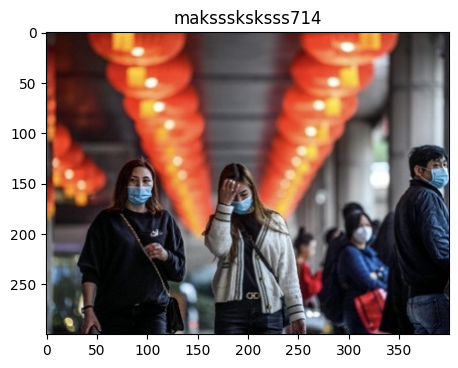

In [147]:
img_name, img_data = list(imgs_with_labels['raw_data'].items())[27]
img = np.copy(img_data['img'])
img = helpers.to_rgb(img)
plt.imshow(img)
plt.gcf().set_dpi(100)
plt.title(img_name)
plt.show()

In [148]:
cropFaces = []
faces = detector.predict(img.astype(np.float32), threshold=0.7)
img = Image.fromarray(img)
for face in faces:
    cropFaces.append(img.crop((face['x1'], face['y1'], face['x2'], face['y2'])))

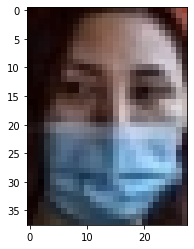

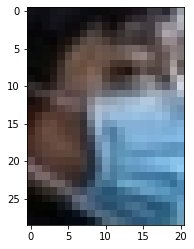

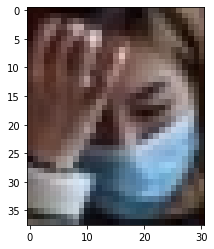

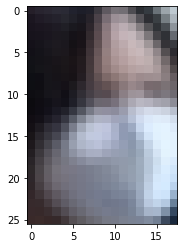

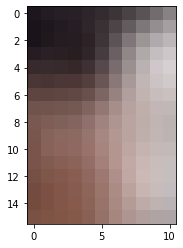

In [149]:
for face in cropFaces:
    plt.figure()
    plt.imshow(face)

In [146]:
for face in cropFaces:
    pred(face)

Mask Val: 0.9769513010978699, Non-mask Val: 0.023048697039484978
Image predicted as [0]
Mask Val: 0.9526138305664062, Non-mask Val: 0.04738617688417435
Image predicted as [0]
Mask Val: 0.9011161923408508, Non-mask Val: 0.09888381510972977
Image predicted as [0]
Mask Val: 0.9920111298561096, Non-mask Val: 0.0079888254404068
Image predicted as [0]
Mask Val: 0.963561475276947, Non-mask Val: 0.03643854707479477
Image predicted as [0]
